Number of lines: 8208
Number of training samples: 6566
Number of validation samples: 1642


Using TensorFlow backend.


Epoch 1/1
39396/39396 [==============================] - 653s - loss: 0.0323 - val_loss: 0.0301
dict_keys(['loss', 'val_loss'])


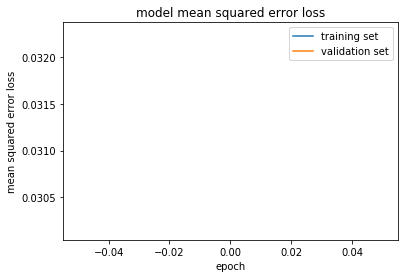

In [1]:
import os
import csv
import cv2
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt

lines = []
with open ('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

print("Number of lines: " + str(len(lines)))     
        
from sklearn.model_selection import train_test_split
train_samples,validation_samples = train_test_split(lines,test_size=0.2)

print("Number of training samples: " + str(len(train_samples)))
print("Number of validation samples: " + str(len(validation_samples)))

batch_size = 32

def generator(samples,batch_size=32):
    random.shuffle(samples)
    num_samples = len(samples)
    while 1:
        for offset in range(0,num_samples,batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                for i in range(3):
                    if i==0:
                        correction = 0
                    elif i==1:
                        correction = 0.2
                    elif i==2:
                        correction = -0.2
                    source_path = line[i]
                    filename = source_path.split('/')[-1]
                    current_path = 'data/IMG/' + filename
                    image = cv2.imread(current_path)
                    brightness = image.mean() + np.random.uniform()
                    image[:, :, 2] = image[:, :, 2] * brightness
                    images.append(image)
                    
                    measurement = float(line[3])+correction
                    
                    prob = np.random.random()   # generates a random number between 0 and 1
                    if prob < 0.7 and measurement < 0.01:
                        # drop 0 angle data with 70% prbability:
                        camera = np.random.choice(['left', 'right'])
                        if camera == "left":
                            measurement += 0.25 
                        elif camera == "right":
                            measurement -= 0.25
           
                    measurements.append(measurement)

            augmented_images, augmented_measurements = [], []
            for image,measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train,y_train)

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

def resize_and_normalize(X_train):
    from keras.backend import tf as ktf
    resized = ktf.image.resize_images(X_train, (64,64))
    resized = resized / 127.5 - 1.0
    return resized

train_generator = generator(train_samples,batch_size=32)
validation_generator = generator(validation_samples,batch_size=32)

#NVidia
model = Sequential()
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
model.add(Lambda(resize_and_normalize))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator,samples_per_epoch = (len(train_samples)*3*2),validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples),nb_epoch=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')